# Probability Course Project

Modeling the lifetime of nodes in a network using distributions and random reliability.

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma, factorial, comb
from scipy.stats import pareto, expon, levy, lognorm, gamma as gamma_dist, invgauss, weibull_min as weibull
from scipy import integrate

## Define Some Functions

### Node Isolation Functions

#### General Function

$\begin{aligned} \pi_r(X)=\int_0^{\infty} P(X>t) f_{\tilde{X}_{r, k}}(t) \mathrm{d} t=\frac{r}{\mu_F^k}\left(\begin{array}{l}k\\r\end{array}\right) \times \int_0^{\infty}\left[\bar{F}^2(t)\left(\int_0^t \bar{F}(u) \mathrm{d} u\right)^{r-1}\left(\int_t^{\infty} \bar{F}(u) \mathrm{d} u\right)^{k-r}\right] \mathrm{d} t \end{aligned}$



In [21]:
def general_isolation(k, r, dist):
    return r / np.power(dist.expect(), k) * comb(k, r) * integrate.quad(lambda t: np.power(dist.sf(t), 2) * np.power(integrate.quad(dist.sf, 0, t)[0], r - 1) * np.power(integrate.quad(dist.sf, t, np.inf)[0], k - r), 0, np.inf)[0]

#### Pareto Distribution

$\begin{aligned}& \pi_r(X)=\frac{k !}{(k-r) !} \cdot \frac{\Gamma\left(k-r+1+\frac{\alpha}{\alpha-1}\right)}{\Gamma\left(k+1+\frac{\alpha}{\alpha-1}\right)} \end{aligned}$

$\alpha > 1, \beta > 0$

In [3]:
def pareto_isolation(k, r, alpha):
    assert(alpha > 1)
    return factorial(k) / factorial(k - r) * gamma(k - r + 1 + (alpha / (alpha - 1))) / gamma(k + 1 + (alpha / (alpha - 1)))

#### Exponential Distribution

$\pi_r(X)=\frac{\begin{aligned}& k-r+1 \end{aligned}}{\begin{aligned}& k+1 \end{aligned}}$

In [4]:
def exponential_isolation(k, r):
    return (k - r + 1) / (k + 1)

#### Uniform Distribution

$\begin{aligned}& \pi_r(X)=\frac{k !}{(k-r) !} \cdot \frac{\Gamma\left(k-r+1+\frac{3}{2}\right)}{\Gamma\left(k+\frac{3}{2}\right)} \end{aligned}$

In [5]:
def uniform_isolation(k, r):
    return factorial(k) / factorial(k - r) * gamma(k - r + 1.5) / gamma(k + 1.5)

## Problem 1

$\begin{aligned} \pi_r(X)=\int_0^{\infty} P(X>t) f_{\tilde{X}_{r, k}}(t) \mathrm{d} t=\frac{r}{\mu_F^k}\left(\begin{array}{l}k\\r\end{array}\right) \times \int_0^{\infty}\left[\bar{F}^2(t)\left(\int_0^t \bar{F}(u) \mathrm{d} u\right)^{r-1}\left(\int_t^{\infty} \bar{F}(u) \mathrm{d} u\right)^{k-r}\right] \mathrm{d} t \end{aligned}$

### Weibull

$f(x, c)=c x^{c-1} \times e^{-x^c}$

$\bar{F}(x)=e^{-x^c}$

$E[X]= \Gamma(1+ \frac{1}{c})$

$\begin{aligned} \int \bar{F}(x) \mathrm{d} x = -\dfrac{\operatorname{\Gamma}\left(\frac{1}{c},x^c\right)}{c} \end{aligned}$

$\begin{aligned} \pi_r(X)=\frac{r}{[\Gamma(1+ \frac{1}{c})]^k}
\left(\begin{array}{l}k\\r\end{array}\right) \times \int_0^{\infty}\left[
    e^{-2x^c}
\left(
    -\dfrac{\operatorname{\Gamma}\left(\frac{1}{c},t^c\right)}{c}
    +\dfrac{\operatorname{\Gamma}\left(\frac{1}{c},0^c\right)}{c}
    \right)
^{r-1}
\left(
    -\dfrac{\operatorname{\Gamma}\left(\frac{1}{c},{\infty}^c\right)}{c}
    +\dfrac{\operatorname{\Gamma}\left(\frac{1}{c},t^c\right)}{c}
    \right)
    ^{k-r}\right] \mathrm{d} t \end{aligned}$

### NWUE-ness Comparison Functions

#### Mean residue lifetime

$\begin{aligned}& \mu_F(t)=E[X-t \mid X>t]=\frac{\begin{aligned}& \int_t^{\infty} \bar{F}(x) d x \end{aligned}}{\begin{aligned}& \bar{F}(t) \end{aligned}} \end{aligned}$

In [6]:
def mean_residue_lifetime(survival_function, t):
    return integrate.quad(survival_function, t, np.inf)[0] / survival_function(t)

$\begin{aligned}& \frac{\mu_F(F^{-1}(v))}{\mu_G(G^{-1}(v))} \geq \frac{\mu_F}{\mu_G} \end{aligned}$ for all $\begin{aligned}& v \in(0,1) \end{aligned}$

$X \geq_{NWUE} Y$

In [7]:
def is_more_nwue(dist_x, dist_y) -> bool:
    v = np.linspace(0.01, 0.99, 500)
    return all(np.array([mean_residue_lifetime(dist_x.sf, dist_x.ppf(i)) / mean_residue_lifetime(dist_y.sf, dist_y.ppf(i)) for i in v]) >= dist_x.expect() / dist_y.expect())

## Problem 2

Prove if $X \geq_{NWUE} Y$ then $\pi_r(X) < \pi_r(Y)$

In [12]:
pareto_shape = 20.0
weibull_shape = 10.0
pareto_scale = 10
expon_lambda = 2

temp = is_more_nwue(expon(scale=(1/expon_lambda)), pareto(b=pareto_shape, scale=pareto_scale))
print(f'expon > pareto? {temp}\nexponential_isolation: {exponential_isolation(10, 5)}, pareto_isolation: {pareto_isolation(10, 5, pareto_shape)}')
temp = is_more_nwue(expon(scale=(1/expon_lambda)), weibull(weibull_shape))
print(f'expon > weibull? {temp}\nexponential_isolation: {exponential_isolation(10, 5)}, weibull_isolation: {general_isolation(10, 5, weibull(weibull_shape))}')

expon > pareto? True
exponential_isolation: 0.5454545454545454, pareto_isolation: 0.5293860019988013
expon > weibull? True
exponential_isolation: 0.5454545454545454, weibull_isolation: 0.9966519589521731


## Problem 3

Prove if $X$, $Y$, $T$ are random variables of Pareto, exponential and uniform distribution then $\pi_r(X) < \pi_r(Y) < \pi_r(T)$

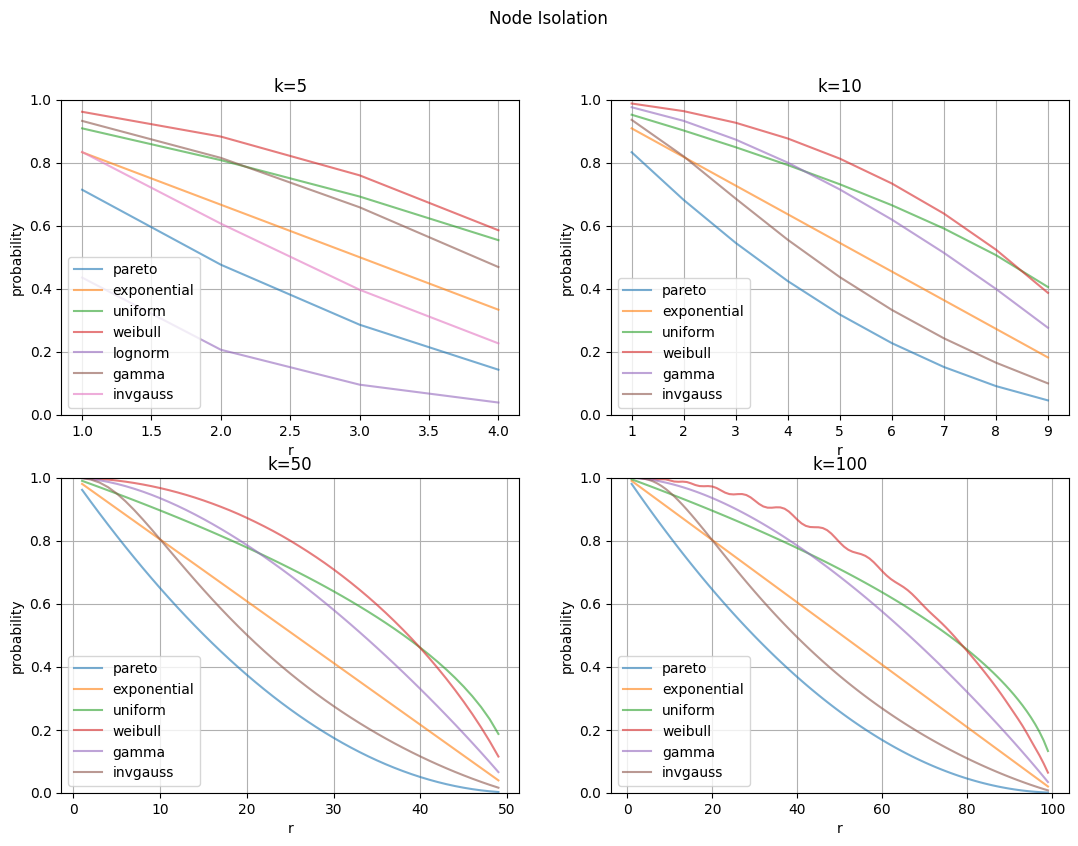

In [11]:
shape = 2.0
color_alpha = 0.6
count_of_neighbors = (5, 10, 50, 100)

def plot_isolation_probabilities(k, axes):
    r = np.arange(1, k)
    axes.plot(r, np.array([pareto_isolation(k, i, shape) for i in r]), alpha=color_alpha, label='pareto')
    axes.plot(r, np.array([exponential_isolation(k, i) for i in r]), alpha=color_alpha, label='exponential')
    axes.plot(r, np.array([uniform_isolation(k, i) for i in r]), alpha=color_alpha, label='uniform')
    axes.plot(r, np.array([general_isolation(k, i, weibull(shape)) for i in r]), alpha=color_alpha, label='weibull')
    # axes.plot(r, np.array([general_isolation(k, i, levy()) for i in r]), alpha=color_alpha, label='levy')
    if k <= 5:
      axes.plot(r, np.array([general_isolation(k, i, lognorm(shape)) for i in r]), alpha=color_alpha, label='lognorm')
    axes.plot(r, np.array([general_isolation(k, i, gamma_dist(shape)) for i in r]), alpha=color_alpha, label='gamma')
    axes.plot(r, np.array([general_isolation(k, i, invgauss(shape)) for i in r]), alpha=color_alpha, label='invgauss')


fig, ax = plt.subplots(2, 2, figsize=(13, 9))
ax = ax.flatten()
fig.suptitle('Node Isolation')
for i, j in zip(ax, count_of_neighbors):
    plot_isolation_probabilities(k=j, axes=i)
    i.legend()
    i.grid(True)
    i.set_title(f'k={j}')
    i.set_xlabel('r')
    i.set_ylabel('probability')
    i.set_ylim(0, 1)

## Find NWUE-ness with Hypothesis Testing

$\begin{aligned} \beta(X)=\int_0^{\infty} \bar{F}^2(t) d t \end{aligned}$

$\begin{aligned} \beta(Y)=\int_0^{\infty} \bar{G}^2(t) d t \end{aligned}$

In [13]:
def beta(dist):
    return integrate.quad(lambda x: np.power(dist.sf(x), 2), 0, np.inf)[0]

$\Delta(X, Y)=\beta(X) / \mu_F-\beta(Y) / \mu_G$

In [14]:
def delta(dist_x, dist_y):
    return beta(dist_x) / dist_x.expect() - beta(dist_y) / dist_y.expect()

$\begin{aligned} S^2\left(X_n, Y_m\right)=\frac{m}{n+m} \cdot \frac{S^2\left(X_n\right)}{\bar{X}^2}+\frac{n}{n+m} \cdot \frac{S^2\left(Y_m\right)}{\bar{Y}^2} \end{aligned}$

In [15]:
def s_2(dist_x, dist_y, n, m):
    return m / (n + m) * dist_x.var() / np.power(dist_x.expect(), 2) + n / (n + m) * dist_y.var() / np.power(dist_y.expect(), 2)

$\begin{aligned} T\left(X_n, Y_m\right)=\sqrt{\frac{n m}{n+m}} \cdot \frac{\Delta\left(X_n, Y_m\right)}{\sqrt{S^2\left(X_n, Y_m\right)}} \end{aligned}$

In [16]:
def T(dist_x, dist_y, n, m):
    return np.sqrt(n * m / (n + m)) * delta(dist_x, dist_y) / np.sqrt(s_2(dist_x, dist_y, n, m))

## Problem 5

Define parameters:

In [17]:
pareto_shape = 20.0
weibull_shape = 20.0
pareto_scale = 10
weibull_scale = 10.7
expon_lambda = 2
expon_scale = 10

pareto_dist = pareto(b=pareto_shape, scale=pareto_scale)
weibull_dist = weibull(c=weibull_shape, scale=weibull_scale)
expon_dist = expon(scale=(1/expon_lambda), loc=expon_scale)

Mean, median and NWUE value:

In [18]:
print(f'Pareto Mean: {pareto_dist.expect()}, Pareto Median: {pareto_dist.median()}')
print(f'Weibull Mean: {weibull_dist.expect()}, Weibull Median: {weibull_dist.median()}')
print(f'Exponential Mean: {expon_dist.expect()}, Exponential Median: {expon_dist.median()}')

print(f'NWUE Pareto-Weibull: {T(pareto_dist, weibull_dist, 30, 32)}')
print(f'NWUE Pareto-Exponential: {T(expon_dist, pareto_dist, 30, 32)}')
print(f'NWUE Weibull-Exponential: {T(expon_dist, weibull_dist, 30, 32)}')

Pareto Mean: 10.526315789473706, Pareto Median: 10.352649238413775
Weibull Mean: 10.416495641521697, Weibull Median: 10.505701349205927
Exponential Mean: 10.499999999999982, Exponential Median: 10.346573590279972
NWUE Pareto-Weibull: 0.5776177954266039
NWUE Pareto-Exponential: 0.14372282243713624
NWUE Weibull-Exponential: 0.733152015329698


What happen for NWUE value if the scale parameter is changed?

(0.0, 1.0)

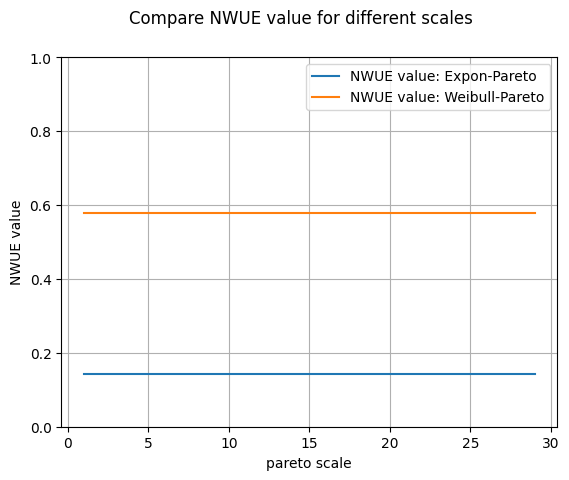

In [20]:
pareto_scale = np.arange(1, 30)
nwue_value_expon_pareto = np.array([T(expon_dist, pareto(b=pareto_shape, scale=i), 30, 32) for i in pareto_scale])
nwue_value_weibull_pareto = np.array([T(pareto(b=pareto_shape, scale=i), weibull_dist, 30, 32) for i in pareto_scale])

fig, ax = plt.subplots(1, 1)
fig.suptitle('Compare NWUE value for different scales')
ax.plot(pareto_scale, nwue_value_expon_pareto, label='NWUE value: Expon-Pareto')
ax.plot(pareto_scale, nwue_value_weibull_pareto, label='NWUE value: Weibull-Pareto')
ax.legend()
ax.grid(True)
ax.set_xlabel('pareto scale')
ax.set_ylabel('NWUE value')
ax.set_ylim(0, 1)

$\left\{\begin{array}{l}H_0: X \sim Y \\ H_A: X \nsim Y\end{array}\right.$

$2 \times \min \{\mathbb{P}\{T \geqslant 0.5\}\}$